# Подготовка данных

1. Собрать датасет от 15 изображений одно персонажа (Чем более разнооразнее и больше данных тем лучше будет качество)
2. Кропнуть и заресайзить лица, тут можно обрабатывать сразу все https://www.birme.net/



## Install Requirements

In [1]:
!git clone https://github.com/huggingface/diffusers
# !pip install git+https://github.com/huggingface/diffusers
# !pip install triton --ignore-installed keyring packaging
# !pip install accelerate transformers ftfy gradio natsort safetensors --ignore-installed keyring packaging
# !pip install bitsandbytes --ignore-installed keyring packaging

Cloning into 'diffusers'...
remote: Enumerating objects: 60349, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 60349 (delta 171), reused 130 (delta 66), pack-reused 60052
Receiving objects: 100% (60349/60349), 41.70 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (43914/43914), done.


In [5]:
# !pip install pyopenssl --upgrade

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 997.7 kB/s eta 0:00:00a 0:00:01


In [19]:
# !wget -O civitai_midel.ckpt https://civitai.com/api/download/models/201259?type=Model&format=SafeTensor&size=pruned&fp=fp16

## Download model and convert model

In [8]:
# !wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml

--2024-04-17 00:46:43--  https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1873 (1,8K) [text/plain]
Saving to: ‘v1-inference.yaml’

v1-inference.yaml   100%[===================>]   1,83K  --.-KB/s    in 0s      

2024-04-17 00:46:43 (17,7 MB/s) - ‘v1-inference.yaml’ saved [1873/1873]



In [2]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='./civitai_midel.ckpt'\
      --original_config_file='./v1-inference.yaml'\
      --dump_path='./cache_dir/models/civitai_model'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors

/home/user/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(
/usr/lib/python3/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/user/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### Сохранить копию на диск чтобы не конвертировать веса при каждом запуске

In [3]:
!cp -r ./cache_dir/models/civitai_model/ ./CyberRealistic

## Settings and run

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [34]:
import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation"

import gc
import torch
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [21]:
!rm -r ./birme-512x512/.ipynb_checkpoints

rm: cannot remove './birme-512x512/.ipynb_checkpoints': No such file or directory


In [22]:

!python3 ./diffusers/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a portrait of sks man face" \
  --class_prompt="a portrait of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --logging_dir $OUTPUT_DIR/log_dir


/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
04/22/2024 01:04:47 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
04/22/2024 01:04:50 - INFO - __main__ - ***** Running training *****
04/22/2024 01:04:50 - INFO - __main__ -   Num e

## Inference

In [23]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

model_path = './db_generation'

pipe = StableDiffusionPipeline.from_pretrained(
    model_path, safety_checker=None, torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda = None


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [24]:
# @markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device="cuda")
seed = 345252  # @param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/35 [00:00<?, ?it/s]

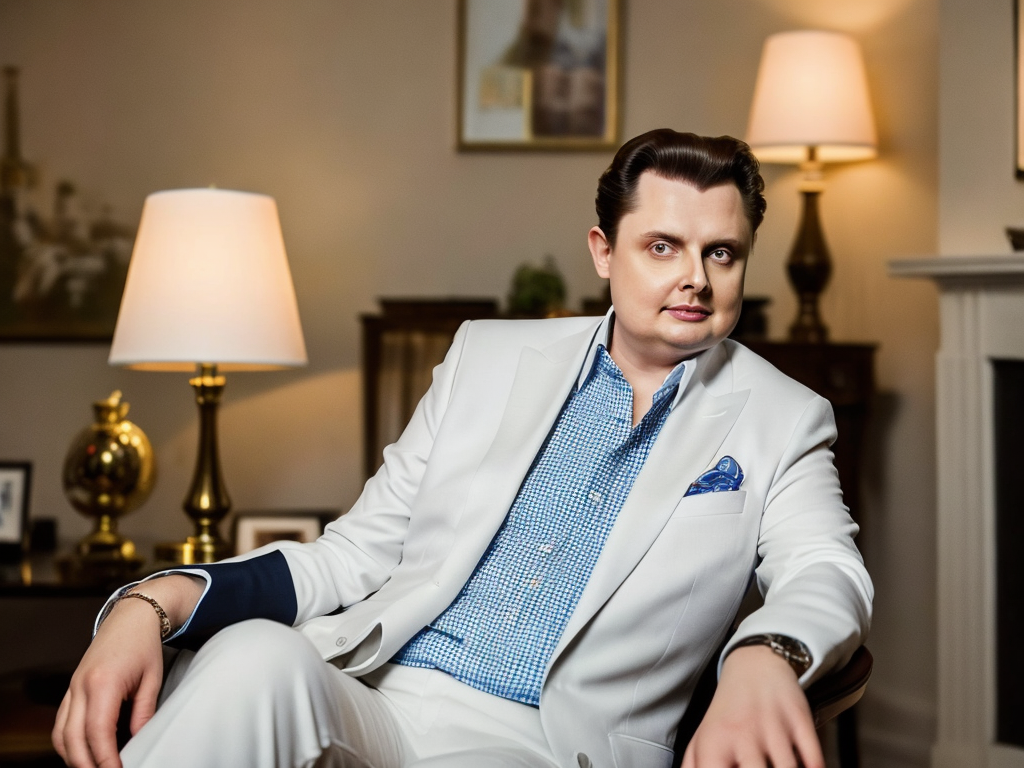

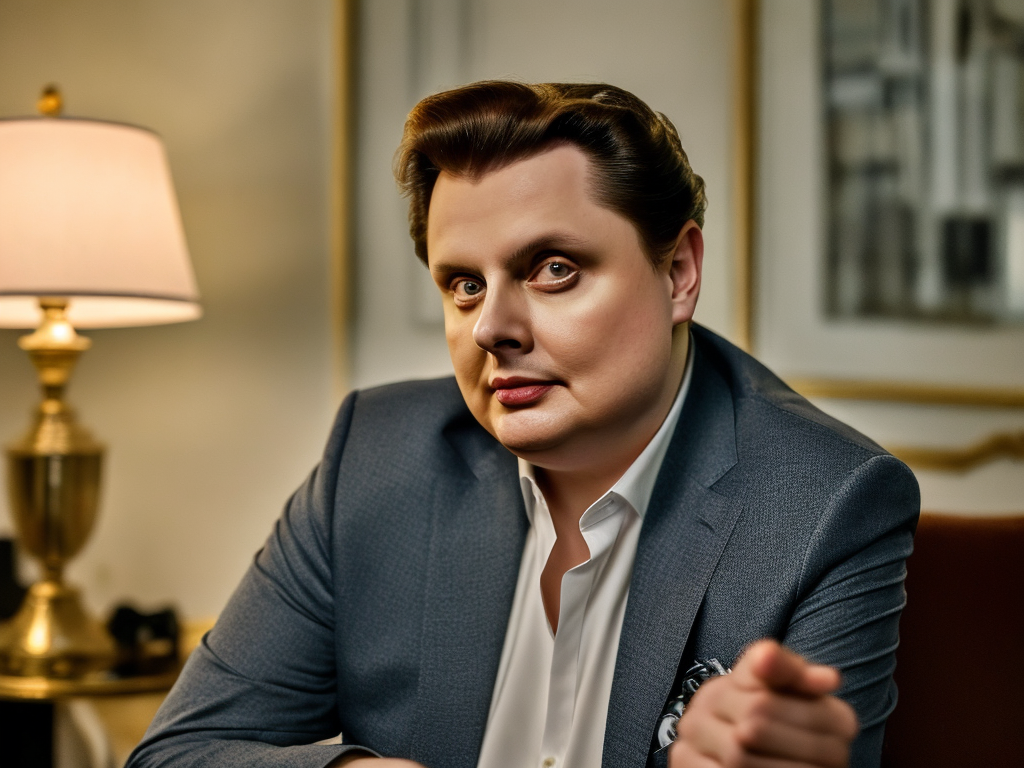

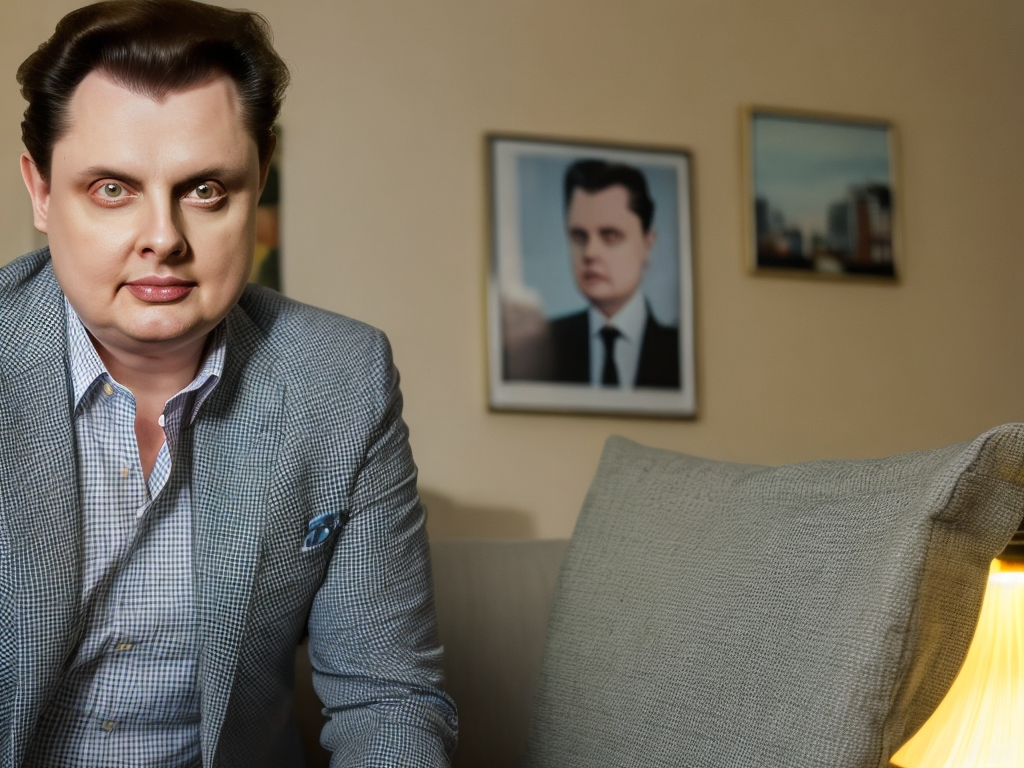

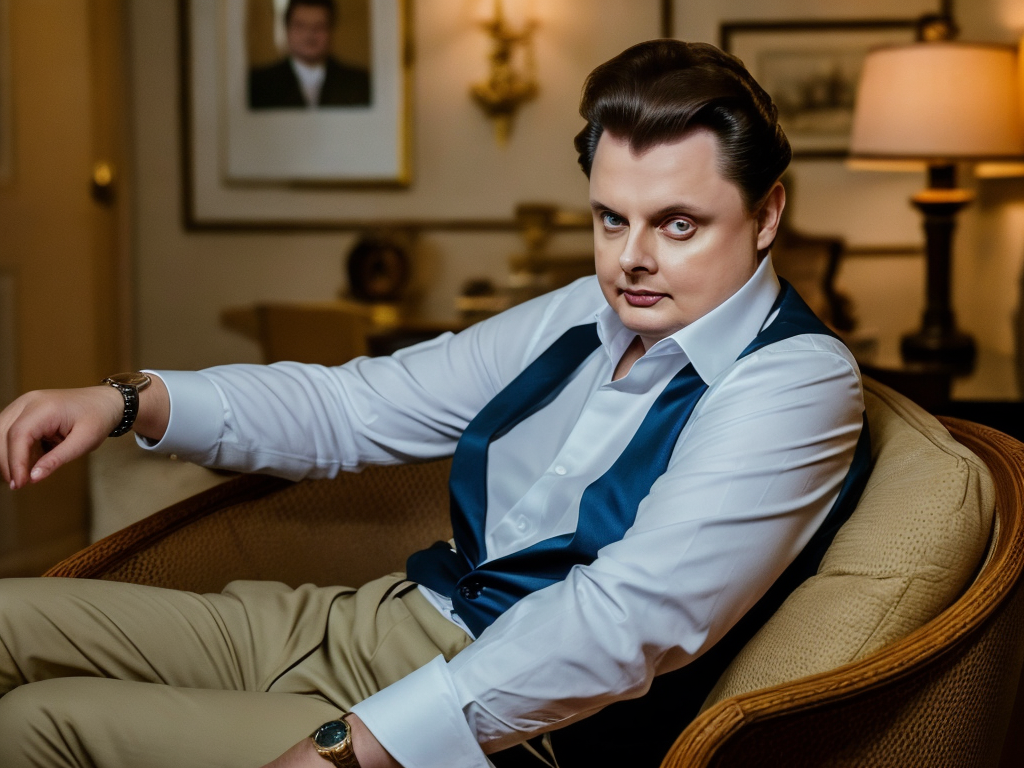

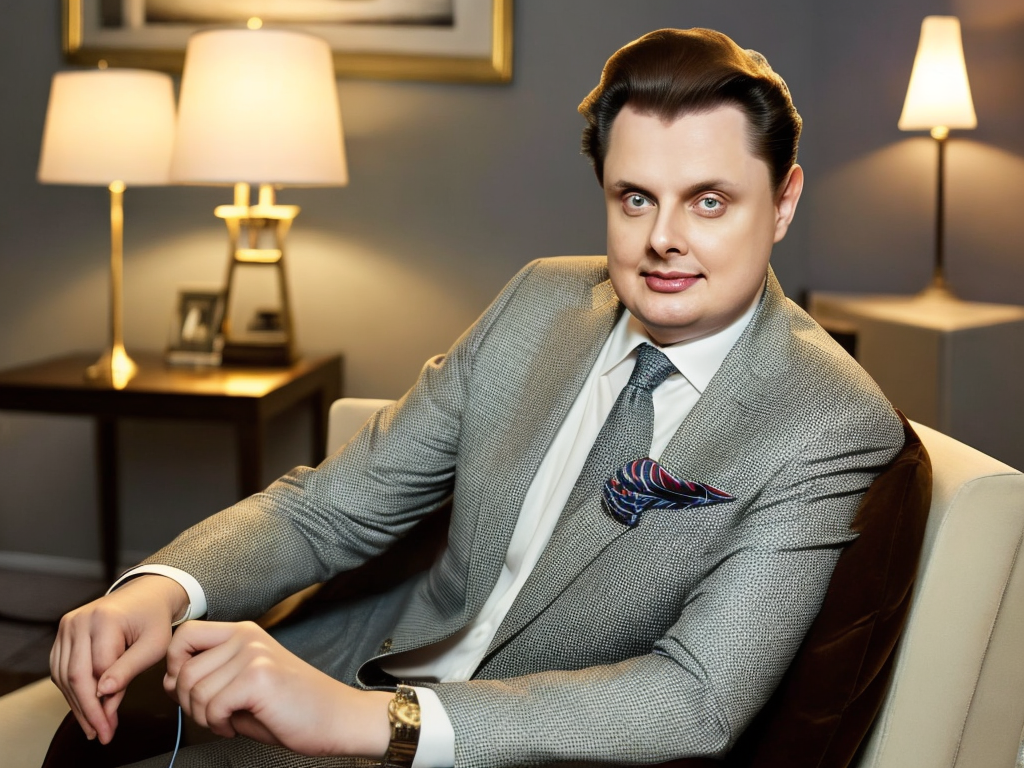

In [25]:
# @title Run for generating images.

prompt = "portrait of sks man face, in the apartment, lamp light, day, sitting on a chair, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes"  # @param {type:"string"}
# prompt = "portrait of sks man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes"  # @param {type:"string"}

negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, extra limb, missing limb, floating limbs, mutated arms, severed limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
# negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
num_samples = 5  # @param {type:"number"}
guidance_scale = 7.5  # @param {type:"number"}
num_inference_steps = 35  # @param {type:"number"}
height = 768  # @param {type:"number"}
width = 1024  # @param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda,
    ).images

for img in images:
    display(img)

In [26]:
token = "sks"
promt_list = [
    {
        "name": "kitchen",
        "prompt": f"close up portrait of {token} man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "forest",
        "prompt": f"portrait of {token} man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
        "name": "street",
        "prompt": f"portrait of {token} man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
    {
        "name": "apartment",
        "prompt": f"portrait of {token} man face, in the apartment, lamp light, day, sitting on a chair, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
    {
        "name": "office",
        "prompt": f"portrait of {token} man face, in the office, light, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
        "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
]

from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [27]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "./carlos_sainz_gen_unet"
# save_mode = "with_train_token"
save_mode = "base_model"

for idx, sample in enumerate(promt_list):
    prompt = sample.get("prompt")
    negative_prompt = sample.get("n_prompt")
    name = sample.get("name")
    image_list = []
    for _ in range(repeat):
        generator = torch.Generator("cuda").manual_seed(seed)
        with autocast("cuda"), torch.inference_mode():
            images = pipe(
                prompt,
                height=height,
                width=width,
                negative_prompt=negative_prompt,
                num_images_per_prompt=num_samples,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        image_list.extend(images)
        seed += 345324

    img_grid = image_grid(image_list, num_samples, repeat)
    save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
    os.makedirs(save_path, exist_ok=True)
    img_grid.save(os.path.join(save_path, f"{name}.jpg"))

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [30]:
# Train lora
# https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py

# load lora
# pipe.load_lora_weights("path/to/weights/diffusion_pytorch_lora.bin")

In [ ]:
# Train lora
# https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py

# load lora
# pipe.load_lora_weights("path/to/weights/diffusion_pytorch_lora.bin")

# LORA train

In [35]:
!pip install peft

Defaulting to user installation because normal site-packages is not writeable
  Using cached triton-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (167.9 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Rolling back uninstall of triton
  Moving to /home/user/.local/lib/python3.10/site-packages/triton-2.3.0.dist-info/
   from /home/user/.local/lib/python3.10/site-packages/~riton-2.3.0.dist-info
  Moving to /home/user/.local/lib/python3.10/site-packages/triton/_C/
   from /home/user/.local/lib/python3.10/site-packages/triton/~C
  Moving to /home/user/.local/lib/python3.10/site-packages/triton/__init__.py
   from /tmp/pip-uninstall-jqd2q_ou/__init__.py
  Moving to /home/user/.local/lib/python3.10/site-packages/triton/__pycache__/
   from /home/user/.local/lib/python3.10/site-packages/triton/~_pycache__
  Moving to /home/user/.local/lib/python3.10/site-packages/tri

In [36]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_4"

In [37]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 4 \
  --logging_dir $OUTPUT_DIR/log_dir


/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
04/22/2024 01:26:19 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
04/22/2024 01:26:23 - INFO - __main__ - ***** Running training *****
04/22/2024 01:26:23 - INFO - __main__ -   Num e

In [46]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_8"

In [47]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 8 \
  --logging_dir $OUTPUT_DIR/log_dir


/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
04/22/2024 01:40:54 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
04/22/2024 01:40:58 - INFO - __main__ - ***** Running training *****
04/22/2024 01:40:58 - INFO - __main__ -   Num e

In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_16"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 16 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_32"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 32 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_4_lr_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 4 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_8_lr_up"

In [ ]:
!python3 /home/mike/python_files/deep_generative_models/deep_generative_models_saved/HW4/diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 8 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_16_lr_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 16 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_32_lr_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=8e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 32 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_32_lr_up_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 32 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()


import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_16_lr_up_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 16 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_8_lr_up_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 8 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_4_lr_up_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 4 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_4_lr_up_up"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 4 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_2"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=2e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 2 \
  --logging_dir $OUTPUT_DIR/log_dir


In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

import os
os.environ['INSTANCE_DIR'] = "./birme-512x512"
os.environ['CLASS_DIR'] = "./reg_dataset"

os.environ['MODEL_NAME'] = "./CyberRealistic"
os.environ['OUTPUT_DIR'] = "./db_generation_lora_rank_4_lr_half"

In [ ]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=2e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank 4 \
  --logging_dir $OUTPUT_DIR/log_dir


# LORA inference

In [39]:
def inference_lora(start_mdoel_path, lora_model_path):
    import torch
    from torch import autocast
    from diffusers import StableDiffusionPipeline, DDIMScheduler
    from IPython.display import display
    import os

    model_path = start_mdoel_path

    pipe = StableDiffusionPipeline.from_pretrained(
        model_path, safety_checker=None, torch_dtype=torch.float16
    ).to("cuda")
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    g_cuda = None
    pipe.load_lora_weights(
        os.path.join(lora_model_path, "pytorch_lora_weights.safetensors")
    )
    g_cuda = torch.Generator(device="cuda")
    seed = 345252  # @param {type:"number"}
    g_cuda.manual_seed(seed)
    prompt = "portrait of sks man face, in the apartment, lamp light, day, sitting on a chair, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes"  # @param {type:"string"}
    # prompt = "portrait of sks man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes"  # @param {type:"string"}

    negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, extra limb, missing limb, floating limbs, mutated arms, severed limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
    # negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation"  # @param {type:"string"}
    num_samples = 5  # @param {type:"number"}
    guidance_scale = 7.5  # @param {type:"number"}
    num_inference_steps = 35  # @param {type:"number"}
    height = 768  # @param {type:"number"}
    width = 1024  # @param {type:"number"}

    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=g_cuda,
        ).images

    for img in images:
        display(img)
    token = "sks"
    promt_list = [
        {
            "name": "kitchen",
            "prompt": f"close up portrait of {token} man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
            "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
        },
        {
            "name": "forest",
            "prompt": f"portrait of {token} man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
            "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
        },
        {
            "name": "street",
            "prompt": f"portrait of {token} man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
            "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
        },
        {
            "name": "apartment",
            "prompt": f"portrait of {token} man face, in the apartment, lamp light, day, sitting on a chair, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
            "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
        },
        {
            "name": "office",
            "prompt": f"portrait of {token} man face, in the office, light, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, beautiful eyes, detailed eyes",
            "n_prompt": "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
        },
    ]

    from PIL import Image

    def image_grid(imgs, rows, cols):
        assert len(imgs) == rows * cols

        w, h = imgs[0].size
        grid = Image.new("RGB", size=(cols * w, rows * h))
        grid_w, grid_h = grid.size

        for i, img in enumerate(imgs):
            grid.paste(img, box=(i % cols * w, i // cols * h))
        return grid

    seed = 147525234
    repeat = 2
    num_samples = 2
    guidance_scale = 7.5
    num_inference_steps = 35
    height = 768
    width = 1024

    save_folder = os.path.join(lora_model_path, "inf_gen")
    # save_mode = "with_train_token"
    save_mode = "base_model"

    for idx, sample in enumerate(promt_list):
        prompt = sample.get("prompt")
        negative_prompt = sample.get("n_prompt")
        name = sample.get("name")
        image_list = []
        for _ in range(repeat):
            generator = torch.Generator("cuda").manual_seed(seed)
            with autocast("cuda"), torch.inference_mode():
                images = pipe(
                    prompt,
                    height=height,
                    width=width,
                    negative_prompt=negative_prompt,
                    num_images_per_prompt=num_samples,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    generator=generator,
                ).images
            image_list.extend(images)
            seed += 345324

        img_grid = image_grid(image_list, num_samples, repeat)
        save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
        os.makedirs(save_path, exist_ok=True)
        img_grid.save(os.path.join(save_path, f"{name}.jpg"))

## rank 32 lr 8e-4

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_32_lr_up",
)

## rank 16 lr 8e-4

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_16_lr_up",
)

## rank 8 lr 8e-4

In [40]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_8_lr_up",
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './db_generation_lora_rank_8_lr_up/pytorch_lora_weights.safetensors'. Use `repo_type` argument if needed.

## rank 4 lr 8e-4

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_4_lr_up",
)

## rank 32 lr 8e-5

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_32",
)

## rank 16 lr 8e-5

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_16",
)

## rank 8 lr 8e-5

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_8",
)

## rank 4 lr 8e-5

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_4",
)

## rank 32 lr 5e-3

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_32_lr_up_up",
)

## rank 16 lr 5e-3

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_16_lr_up_up",
)

## rank 8 lr 5e-3

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_8_lr_up_up",
)

## rank 4 lr 5e-3

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_4_lr_up_up",
)

## rank 2 lr 2e-4

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_2",
)

## rank 4 lr 2e-4

In [ ]:
inference_lora(
    "./CyberRealistic",
    "./db_generation_lora_rank_4_lr_half",
)

# Controlnet

In [ ]:
# !pip install controlnet_aux
# !pip install diffusers transformers xformers git+https://github.com/huggingface/accelerate.git

## Unet

In [48]:
model_path = "./db_generation"

In [49]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
)

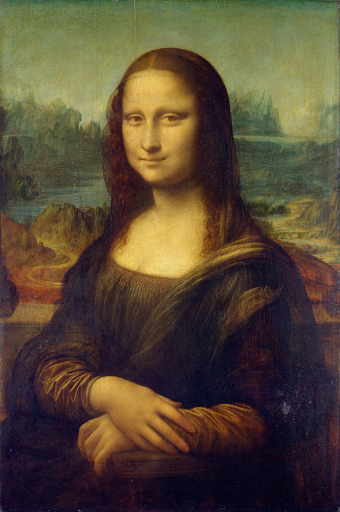

In [50]:
size = (340, 512)
image = image.resize(size)
image

In [ ]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [52]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [53]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [54]:
pipe.enable_model_cpu_offload()

In [55]:
# pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/40 [00:00<?, ?it/s]

1
1 1


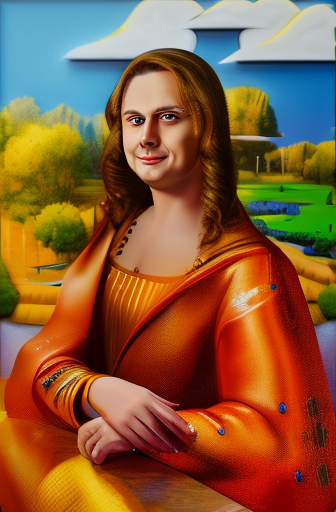

In [56]:
def image_grid(imgs, rows, cols):
    print(len(imgs))
    print(rows, cols)
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


prompt = ", best quality, extremely detailed, 4k, hdr, super resolution"
prompt = [
    t + prompt
    for t in ["portrait of sks man",]
]
generator = [
    torch.Generator(device="cpu").manual_seed(147525234) for i in range(len(prompt))
]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=[
        "monochrome, lowres, bad anatomy, worst quality, low quality"
    ]
    * len(prompt),
    generator=generator,
    num_inference_steps=40,
)

image_grid(output.images, 1, 1)

In [57]:
model_id = "sd-dreambooth-library/quino"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, controlnet, scheduler, safety_checker, feature_extractor, image_encoder to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


In [58]:
generator = torch.manual_seed(147525234)
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=40,
)

  0%|          | 0/40 [00:00<?, ?it/s]

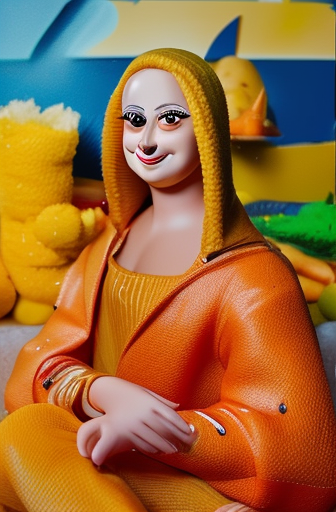

In [59]:
output.images[0]

In [ ]:
yoga_dir = "./yoga"
paths = os.listdir('./yoga')
imgs = [
    load_image(
        os.path.join(yoga_dir, path)
    )
    for path in paths
]

image_grid(imgs, 2, 2)

In [ ]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [62]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose",
    torch_dtype=torch.float16,
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()
# pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/user/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(147525234) for i in range(4)]
prompt = "super-hero sks character, best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=[
        "monochrome, lowres, bad anatomy, worst quality, low quality"
    ]
    * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

## Lora

In [64]:
model_path = "./db_generation"
lora_model_path = "./db_generation_lora_rank_8"

In [65]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
)

In [ ]:
size = (340, 512)
image = image.resize(size)
image

In [ ]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [68]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.load_lora_weights(
    os.path.join(lora_model_path, "pytorch_lora_weights.safetensors")
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [69]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [70]:
pipe.enable_model_cpu_offload()

In [71]:
# pipe.enable_xformers_memory_efficient_attention()

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


prompt = ", best quality, extremely detailed, 4k, hdr, super resolution"
prompt = [
    t + prompt
    for t in ["portrait of sks man",]
]
generator = [
    torch.Generator(device="cpu").manual_seed(14752523) for i in range(len(prompt))
]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=[
        "monochrome, lowres, bad anatomy, worst quality, low quality"
    ]
    * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 1, 1)

In [82]:
model_id = "sd-dreambooth-library/quino"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.load_lora_weights(
    os.path.join(lora_model_path, "pytorch_lora_weights.safetensors")
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [83]:
generator = torch.manual_seed(14752523)
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
output.images[0]

In [ ]:
yoga_dir = "./yoga"
paths = os.listdir('./yoga')
imgs = [
    load_image(
        os.path.join(yoga_dir, path)
    )
    for path in paths
]

image_grid(imgs, 2, 2)

In [ ]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [87]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose",
    torch_dtype=torch.float16,
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.load_lora_weights(
    os.path.join(lora_model_path, "pytorch_lora_weights.safetensors")
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()
# pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(14752523) for i in range(4)]
prompt = "super-hero sks character, best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=[
        "monochrome, lowres, bad anatomy, worst quality, low quality"
    ]
    * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)